##### 백엔드 코드

In [1]:
import pandas as pd

# 데이터 불러오기 
data = pd.read_csv('raw_data/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')
data.head(10)
print(data.shape)

C:\Users\jinhy\AppData\Local\Temp\ipykernel_30080\4287711130.py:4: DtypeWarning: Columns (1,2,7,11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('raw_data/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')


(2622133, 38)


In [2]:
### 데이터 파악

# 데이터 타입이 mixed 인 컬럼 : [1, 2, 7, 11, 29] 번 째 컬럼
columns = data.columns # 전체 컬럼
for column in columns:
    print(data[column].apply(type).value_counts())

# mixed 데이터 명명 
mixed_columns_index = [1, 2, 7, 11, 29]
mixed_columns_name = data.columns[mixed_columns_index]

# Major 데이터 타입 확인
for column in mixed_columns_name:
    print(data[column].apply(type).unique())
    print(data[column].apply(type).value_counts())

# Minor 데이터 정체 확인 
## 1, 'Health Service Area', 'Hospital County', 'Patient Disposition' -> 결측치 처리 필요
## 2. 'Zip Code - 3 digits' -> 환자 거주지역을 나타내는 의미없는 데이터 -> Drop 
for column in mixed_columns_name:
    not_str_index = data[column].apply(lambda x: type(x) == str)
    print(data[column][~not_str_index].value_counts(dropna=False))


index
<class 'int'>    2622133
Name: count, dtype: int64
Health Service Area
<class 'str'>      2617246
<class 'float'>       4887
Name: count, dtype: int64
Hospital County
<class 'str'>      2617246
<class 'float'>       4887
Name: count, dtype: int64
Operating Certificate Number
<class 'float'>    2622133
Name: count, dtype: int64
Facility ID
<class 'float'>    2622133
Name: count, dtype: int64
Facility Name
<class 'str'>    2622133
Name: count, dtype: int64
Age Group
<class 'str'>    2622133
Name: count, dtype: int64
Zip Code - 3 digits
<class 'str'>      2061890
<class 'int'>       524288
<class 'float'>      35955
Name: count, dtype: int64
Gender
<class 'str'>    2622133
Name: count, dtype: int64
Race
<class 'str'>    2622133
Name: count, dtype: int64
Ethnicity
<class 'str'>    2622133
Name: count, dtype: int64
Length of Stay
<class 'str'>    2523136
<class 'int'>      98997
Name: count, dtype: int64
Type of Admission
<class 'str'>    2622133
Name: count, dtype: int64
Patient Disp

In [3]:
##########################################
# 데이터 전처리 - 결측치 및 비정상적인 값 처리
##########################################

pd.set_option('display.max_columns', None)

# 'Length of Stay' 컬럼 처리
## 문자열 등 비정상적인 값은 NaN으로 변환
data['Length of Stay'] = pd.to_numeric(data['Length of Stay'], errors='coerce')
## NaN이 된 행은 제거
df = data.dropna(subset=['Length of Stay'])
## float → int 로 형변환 (NaN 제거되었으므로 안전)
df['Length of Stay'] = df['Length of Stay'].astype(int)

# NaN 개수가 너무 많은 컬럼 제거
## Source of Payment 2, Source of Payment 3, Operating Provider License Number, Other Provider License Number 컬럼
nan_columns = df.columns[df.isna().sum() > 10_000]
df = df.drop(columns=nan_columns)

# 의미없는 컬럼 제거 
# 'Zip Code - 3 digits'(우편번호) / 'index'(인덱스)
# 'Attending Provider License Number'(주치의 면허번호) / 'Operating Certificate Number'(운영 인증 번호)
df = df.drop(columns=['Zip Code - 3 digits', 'index', 'Attending Provider License Number', 'Operating Certificate Number'])


# Weight(몸무게) 값이 0이 과도하게 많아 의미 없는 컬럼 제거
# 'Birth Weight' 컬럼 삭제
# df = df.drop(columns=['Birth Weight'])

C:\Users\jinhy\AppData\Local\Temp\ipykernel_30080\1877454220.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Length of Stay'] = df['Length of Stay'].astype(int)


In [23]:
### 데이터 전처리 - 이상치 처리 
from utils.cate_outlier import preview_rare_categories, replace_rare_categories
from utils.num_outlier import plot_zscore_outliers_all, remove_zscore_outliers_all
import pandas as pd

num_columns = ['Total Charges', 'Total Costs', 'Length of Stay']
cate_columns = [col for col in df.columns
                if col not in num_columns + ['Patient Disposition']] # target = 'Patient Disposition'

## 범주형 이상치 확인
preview_rare_categories(df, columns=cate_columns, threshold=0.01)

'Health Service Area' 컬럼에는 희귀 범주 없음
'Hospital County' 컬럼에서 희귀 범주 발견 (40개): ['Schenectady', 'Niagara', 'Chemung', 'Warren', 'Rensselaer', 'Otsego', 'Ulster', 'St Lawrence', 'Chautauqua', 'Ontario', 'Jefferson', 'Clinton', 'Saratoga', 'Steuben', 'Putnam', 'Cattaraugus', 'Montgomery', 'Oswego', 'Tompkins', 'Franklin', 'Columbia', 'Sullivan', 'Cayuga', 'Madison', 'Genesee', 'Cortland', 'Wayne', 'Fulton', 'Wyoming', 'Livingston', 'Orleans', 'Allegany', 'Chenango', 'Lewis', 'Delaware', 'Schuyler', 'Herkimer', 'Yates', 'Essex', 'Schoharie']
'Facility ID' 컬럼에서 희귀 범주 발견 (200개): [5.0, 1172.0, 1301.0, 1453.0, 630.0, 1139.0, 1178.0, 636.0, 527.0, 528.0, 181.0, 1176.0, 1165.0, 213.0, 635.0, 1469.0, 3067.0, 1286.0, 924.0, 1318.0, 1628.0, 409.0, 599.0, 1638.0, 1294.0, 207.0, 913.0, 563.0, 1320.0, 1288.0, 1005.0, 1633.0, 1302.0, 1168.0, 1738.0, 1692.0, 471.0, 779.0, 1045.0, 885.0, 776.0, 829.0, 686.0, 943.0, 218.0, 208.0, 1454.0, 3975.0, 3376.0, 552.0, 210.0, 58.0, 1447.0, 1122.0, 1097.0, 598.0, 1445.

'Total Charges' 컬럼 이상치 수 (|Z| > 2): 75301개
'Total Costs' 컬럼 이상치 수 (|Z| > 2): 65946개
'Length of Stay' 컬럼 이상치 수 (|Z| > 2): 94499개


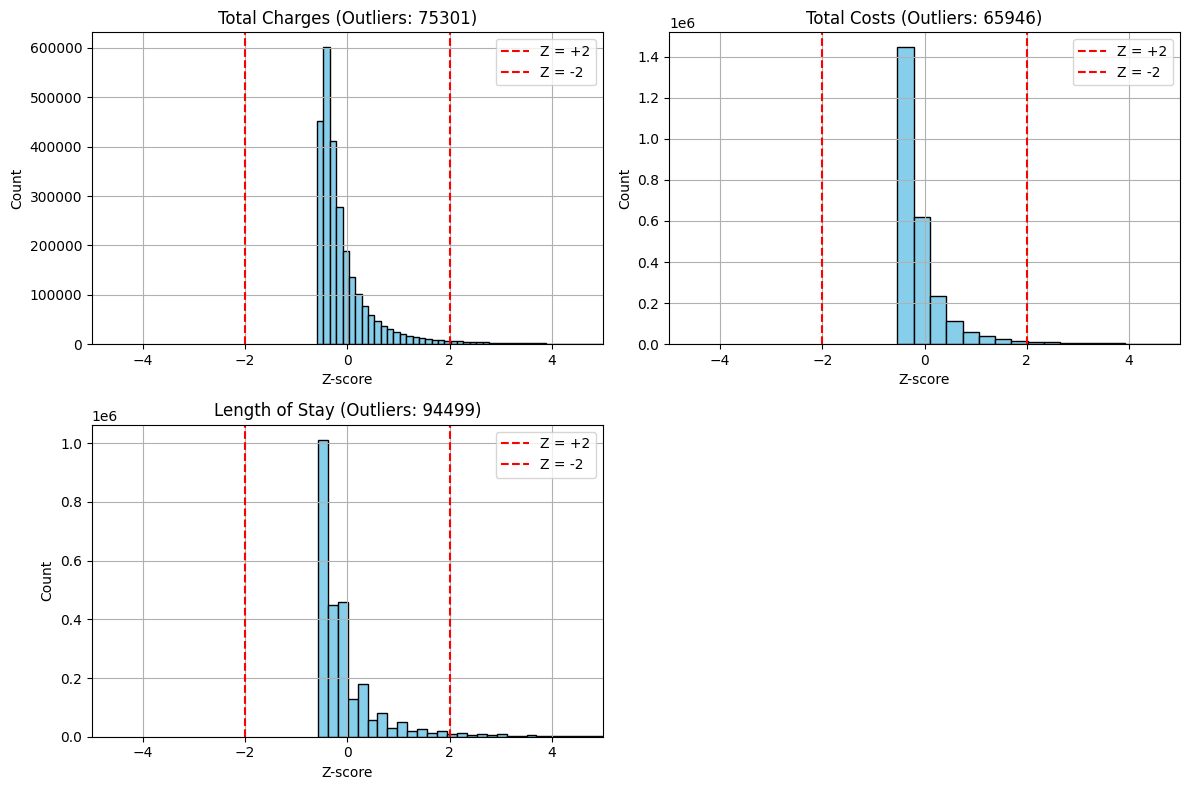

In [24]:
## 1) 수치형 이상치 시각화
bins = [1000, 1000, 80]
plot_zscore_outliers_all(df, columns=num_columns, bins_list=bins, z_thresh=2)

In [25]:
# 이상치 대체 및 삭제

# 1단계: 범주형 컬럼의 희귀값을 'Others'로 대체
df_replaced = replace_rare_categories(df, columns=cate_columns, threshold=0.001)

# 2단계: 수치형 컬럼의 Z-score 이상치를 제거
df_cleaned = remove_zscore_outliers_all(df_replaced, columns=num_columns, z_thresh=2)

df_cleaned.shape

(2481639, 29)

In [26]:
df = df_cleaned

In [95]:
df['Length of Stay'].mean()
df['Length of Stay'].median()

np.float64(3.0)

In [27]:
### 모델 선정 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# -------------------------------
# 대략적인 모델별 성능 비교
# -------------------------------

# -------------------------------
# 공통 전처리 파이프라인 구성
# -------------------------------
# 범주형 데이터 전처리 - Tree based 모델(DecisionTree, RandomForest, XGBoost 등) + Support Vector 모델 
cat_pipeline = make_pipeline( 
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)
# 범주형 데이터 전처리 - 비 Tree based 모델(LogisticRegression 등)
cat2_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)
# 연속형 데이터 전처리
num_pipeline = make_pipeline(
    KNNImputer(n_neighbors=5),
    StandardScaler()
)
# 파이프라인 - Tree based 모델(DecisionTree, RandomForest, XGBoost 등) + Support Vector 모델 
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cate_columns),
    ('num', num_pipeline, num_columns)
])
# 파이프라인 - 비 Tree based 모델(LogisticRegression 등)
preprocessor2 = ColumnTransformer([
    ('cat', cat2_pipeline, cate_columns),
    ('num', num_pipeline, num_columns)
])
# PCA - SVC 모델에만 적용
pca = PCA(n_components=3)
# SMOTE - 오버 샘플링 기법
smote = SMOTE(k_neighbors=4, sampling_strategy=0.1, random_state=42)
# -------------------------------
# 데이터 분할
# -------------------------------

# 이진 분류 문제로 변환 
X = df.drop(columns=['Patient Disposition'])
y = np.where(df['Patient Disposition'].values == 'Left Against Medical Advice', 1, 0)

# 데이터 셋 분할 - 훈련 데이터 1%, 테스트 데이터 0.2%
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.01, test_size=0.002, random_state=42, stratify=y)


# -------------------------------
# 사용할 회귀 모델 정의
# -------------------------------
models = {
    'LogisticRegression' : LogisticRegression(),
    'KNNNeighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    # 'Support Vector Classifier': SVC(probability=True)
}

# -------------------------------
# 모델 학습 및 성능 비교
# -------------------------------
results = []
print("="*20, "이진 분류 모델 성능 비교", "="*20)
for name, model in models.items():

    # 레이블 인코딩을 사용하는 모델
    if name in ['KNNNeighbors', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']:
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('model', model)
        ])
    # SVC 모델 - PCA 적용
    elif name == 'Support Vector Classifier':
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('pca', pca),
        ('model', model)
        ])
    # LogisticRegression 모델 - OneHotEncoding 적용
    else:
        pipeline = Pipeline([
        ('preprocessor', preprocessor2),
        ('smote', smote),
        ('model', model)
        ])

    # 모델 학습
    pipeline.fit(X_train, y_train)
    # 모델 예측
    y_pred_proba = pipeline.predict_proba(X_test)
    # Threshold : 0.5
    y_pred = np.where(y_pred_proba[:, 1] > 0.5, 1, 0)

    # 평가지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # 결과 저장
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"[{name}] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

==================== 이진 분류 모델 성능 비교 ====================
[LogisticRegression] Accuracy: 0.9710, Precision: 0.3824, Recall: 0.4643, F1 Score: 0.4194
[KNNNeighbors] Accuracy: 0.9531, Precision: 0.1990, Recall: 0.3571, F1 Score: 0.2556
[Decision Tree] Accuracy: 0.9694, Precision: 0.3438, Recall: 0.3929, F1 Score: 0.3667
[Random Forest] Accuracy: 0.9843, Precision: 0.9474, Recall: 0.3214, F1 Score: 0.4800
[Gradient Boosting] Accuracy: 0.9845, Precision: 1.0000, Recall: 0.3125, F1 Score: 0.4762
[XGBoost] Accuracy: 0.9833, Precision: 0.8222, Recall: 0.3304, F1 Score: 0.4713


In [28]:
### 선정된 모델 최적화 및 평가 
from utils.get_best_model import get_best_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (precision_recall_curve, roc_curve,
                    average_precision_score, roc_auc_score,
                    PrecisionRecallDisplay, RocCurveDisplay)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 평가지표 초기화 
results = []

# 이진 분류 문제로 변환 
X = df.drop(columns=['Patient Disposition'])
y = np.where(df['Patient Disposition'].values == 'Left Against Medical Advice', 1, 0)

# 데이터 셋 분할 - 훈련 데이터 10%, 테스트 데이터 2%
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.01, test_size=0.004, random_state=42, stratify=y)


# -------------------------------
## Logistic Regression 모델 최적화
# -------------------------------

from sklearn.linear_model import LogisticRegression

# 파라미터 그리드 설정
params = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}
# 하이퍼 파라미터 튜닝
logistic_model = get_best_model('LogisticRegression', \
                                                LogisticRegression(), params, preprocessor2, X_train, y_train)


# -------------------------------
## PR Curve 및 ROC Curve 시각화
# -------------------------------

# 모델 예측
y_pred_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
prec_logistic, rec_logistic, thresholds = precision_recall_curve(y_test, y_pred_proba_logistic)
ap_logistic = average_precision_score(y_test, y_pred_proba_logistic)

# ROC Curve
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_proba_logistic)
roc_auc_logistic = roc_auc_score(y_test, y_pred_proba_logistic)

# -------------------------------
## 최적 Threshold 를 이용한 평가지표 계산
# -------------------------------

# Best Threshold 찾기 
f1_scores = [f1_score(y_test, y_pred_proba_logistic >= t, zero_division=0) for t in thresholds]
best_threshold_logistic = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold based on F1 Score: {best_threshold_logistic:.2f}")

# 최적 threshold를 사용해 예측값 생성
y_pred_logistic = (y_pred_proba_logistic >= best_threshold_logistic).astype(int)

# 평가지표 계산
logistic_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_logistic),
    'Precision': precision_score(y_test, y_pred_logistic, zero_division=0),
    'Recall': recall_score(y_test, y_pred_logistic, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_logistic, zero_division=0)
}

# 평가지표 저장
results.append({'Model' : 'LogisticRegression', **logistic_scores})



Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\jinhy\anaconda3\envs\dl\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


best parameter: {'model__solver': 'saga', 'model__penalty': 'l1', 'model__C': 0.1}
best score: 0.43798274395782716
Best Threshold based on F1 Score: 0.22


In [29]:
# -------------------------------
## Random Forest 모델 최적화
# -------------------------------

from sklearn.ensemble import RandomForestClassifier
# 파라미터 그리드 설정
params = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
# 하이퍼 파라미터 튜닝
rfc_model = get_best_model('RandomForestClassifier', \
                                                RandomForestClassifier(), params, preprocessor, X_train, y_train)


# -------------------------------
## PR Curve 및 ROC Curve 시각화
# -------------------------------

# 모델 예측
y_pred_proba_rfc = rfc_model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
prec_rfc, rec_rfc, thresholds = precision_recall_curve(y_test, y_pred_proba_rfc)
ap_rfc = average_precision_score(y_test, y_pred_proba_rfc)

# ROC Curve
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_proba_rfc)
roc_auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)

# -------------------------------
## 최적 Threshold 를 이용한 평가지표 계산
# -------------------------------

# Best Threshold 찾기 
f1_scores = [f1_score(y_test, y_pred_proba_rfc >= t, zero_division=0) for t in thresholds]
best_threshold_rfc = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold based on F1 Score: {best_threshold_rfc:.2f}")

# 최적 threshold를 사용해 예측값 생성
y_pred_rfc = (y_pred_proba_rfc >= best_threshold_rfc).astype(int)

# 평가지표 계산
rfc_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_rfc),
    'Precision': precision_score(y_test, y_pred_rfc, zero_division=0),
    'Recall': recall_score(y_test, y_pred_rfc, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_rfc, zero_division=0)
}

# 평가지표 저장
results.append({'Model' : 'RandomForestClassifier', **rfc_scores})


Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameter: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 20}
best score: 0.4400015719579999
Best Threshold based on F1 Score: 0.16


In [30]:
# -------------------------------
## XGBoost 모델 최적화
# -------------------------------

from xgboost import XGBClassifier
# 파라미터 그리드 설정
params = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.5, 0.7, 1.0],
    'model__colsample_bytree': [0.5, 0.7, 1.0]
}
# 하이퍼 파라미터 튜닝
xgb_model = get_best_model('XGBClassifier',\
                                                XGBClassifier(), params, preprocessor, X_train, y_train)


# -------------------------------
## PR Curve 및 ROC Curve 시각화
# -------------------------------

# 모델 예측
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
prec_xgb, rec_xgb, thresholds = precision_recall_curve(y_test, y_pred_proba_xgb)
ap_xgb = average_precision_score(y_test, y_pred_proba_xgb)

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# -------------------------------
## 최적 Threshold 를 이용한 평가지표 계산
# -------------------------------

# Best Threshold 찾기 
f1_scores = [f1_score(y_test, y_pred_proba_xgb >= t, zero_division=0) for t in thresholds]
best_threshold_xgb = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold based on F1 Score: {best_threshold_xgb:.2f}")

# 최적 threshold를 사용해 예측값 생성
y_pred_xgb = (y_pred_proba_xgb >= best_threshold_xgb).astype(int)

# 평가지표 계산
xgb_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb, zero_division=0),
    'Recall': recall_score(y_test, y_pred_xgb, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_xgb, zero_division=0)
}

# 평가지표 저장
results.append({'Model' : 'XGBClassifier', **xgb_scores})


Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameter: {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.2, 'model__colsample_bytree': 1.0}
best score: 0.4646777424156057
Best Threshold based on F1 Score: 0.71


In [57]:
# -------------------------------
## GradientBoosting 모델 최적화
# -------------------------------

from sklearn.ensemble import GradientBoostingClassifier
# 파라미터 그리드 설정
params = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.5, 0.7, 1.0],
    'model__min_samples_split': [2, 5, 10]
}
# 하이퍼 파라미터 튜닝
gb_model = get_best_model('GradientBoosting',\
                                                GradientBoostingClassifier(), params, preprocessor, X_train, y_train)


# -------------------------------
## PR Curve 및 ROC Curve 시각화
# -------------------------------

# 모델 예측
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
prec_gb, rec_gb, thresholds = precision_recall_curve(y_test, y_pred_proba_gb)
ap_gb = average_precision_score(y_test, y_pred_proba_gb)

# ROC Curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

# -------------------------------
## 최적 Threshold 를 이용한 평가지표 계산
# -------------------------------

# Best Threshold 찾기 
f1_scores = [f1_score(y_test, y_pred_proba_gb >= t, zero_division=0) for t in thresholds]
best_threshold_gb = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold based on F1 Score: {best_threshold_gb:.2f}")

# 최적 threshold를 사용해 예측값 생성
y_pred_gb = (y_pred_proba_gb >= best_threshold_gb).astype(int)

# 평가지표 계산
gb_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'Precision': precision_score(y_test, y_pred_gb, zero_division=0),
    'Recall': recall_score(y_test, y_pred_gb, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_gb, zero_division=0)
}

# 평가지표 저장
results.append({'Model' : 'GradientBoosting', **gb_scores})


Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameter: {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__max_depth': 7, 'model__learning_rate': 0.1}
best score: 0.45915510799627834
Best Threshold based on F1 Score: 0.90


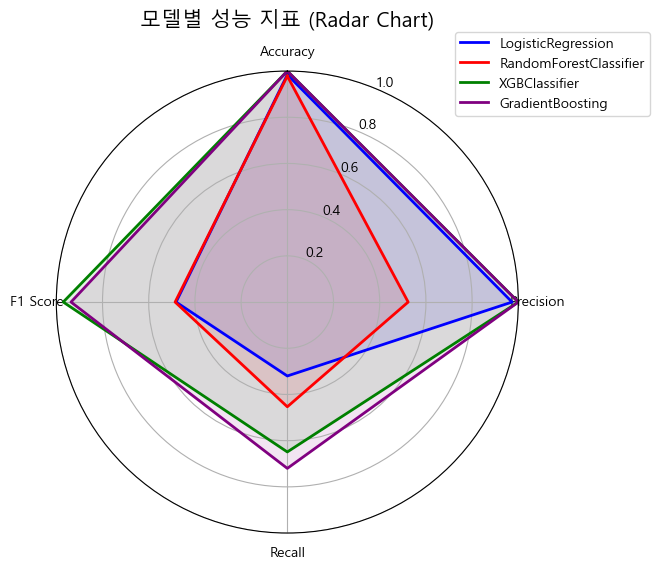

In [67]:
### 모델별 결과 시각화 - 평가지표(Radar Chart)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns
import os

img_dir = 'images'
os.makedirs(img_dir, exist_ok=True)

# 한글 폰트 설정 (Windows 기준)
mpl.rc('font', family='Malgun Gothic')

# 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# 모델별 성능 비교 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')

# 레이더차트 설정
labels = results_df.columns.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 첫 포인트로 되돌아가기

# 차트 초기화
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
plt.title("모델별 성능 지표 (Radar Chart)", size=15, y=1.08)

# 각 모델별로 plot
colors = ['blue', 'red', 'green', 'purple']
for i, (model_name, row) in enumerate(results_df.iterrows()):
    values = row.tolist()  
    if i in [2, 3]:
        values = [min(1, v * 2) for v in values]
    
    values += values[:1]
    ax.plot(angles, values, label=model_name, color=colors[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.1)

# 축 레이블 설정
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# 반지름 값 고정
ax.set_ylim(0, 1)

# 범례
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.savefig(os.path.join(img_dir, 'radar_chart.png'), dpi=300, bbox_inches='tight')
plt.show()

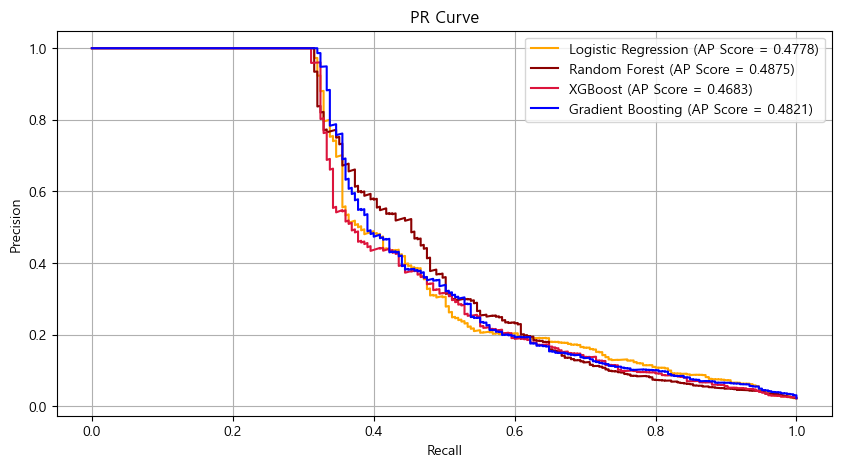

In [53]:
### 모델별 결과 시각화 - PR Curve

plt.figure(figsize=(10, 5))
plt.plot(rec_logistic, prec_logistic, label=f'Logistic Regression (AP Score = {ap_logistic:.4f})', color='orange')
plt.plot(rec_rfc, prec_rfc, label=f'Random Forest (AP Score = {ap_rfc:.4f})', color='darkred')
plt.plot(rec_xgb, prec_xgb, label=f'XGBoost (AP Score = {ap_xgb:.4f})', color='crimson')
plt.plot(rec_gb, prec_gb, label=f'Gradient Boosting (AP Score = {ap_gb:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(img_dir, 'PR_Curve.png'), dpi=300, bbox_inches='tight')
plt.show()


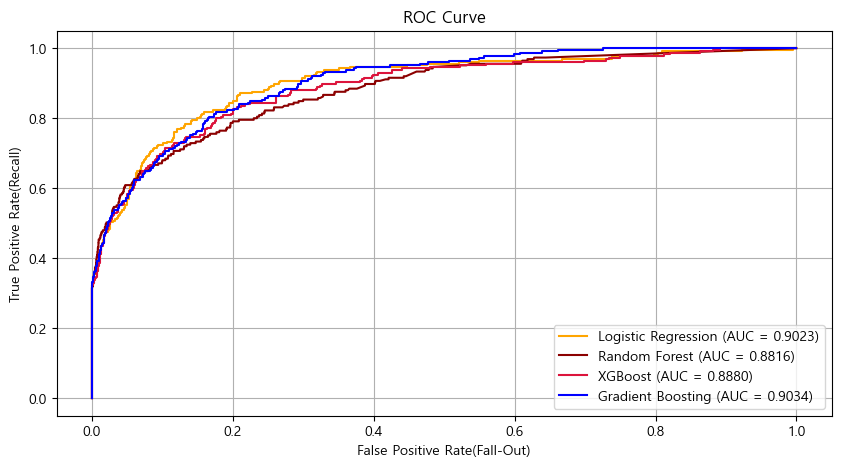

In [54]:
### 모델별 결과 시각화 - ROC Curve

plt.figure(figsize=(10, 5))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {roc_auc_logistic:.4f})', color='orange')
plt.plot(fpr_rfc, tpr_rfc, label=f'Random Forest (AUC = {roc_auc_rfc:.4f})', color='darkred')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})', color='crimson')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})', color='blue')
plt.xlabel('False Positive Rate(Fall-Out)')
plt.ylabel('True Positive Rate(Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(img_dir, 'ROC_Curve.png'), dpi=300, bbox_inches='tight')
plt.show()


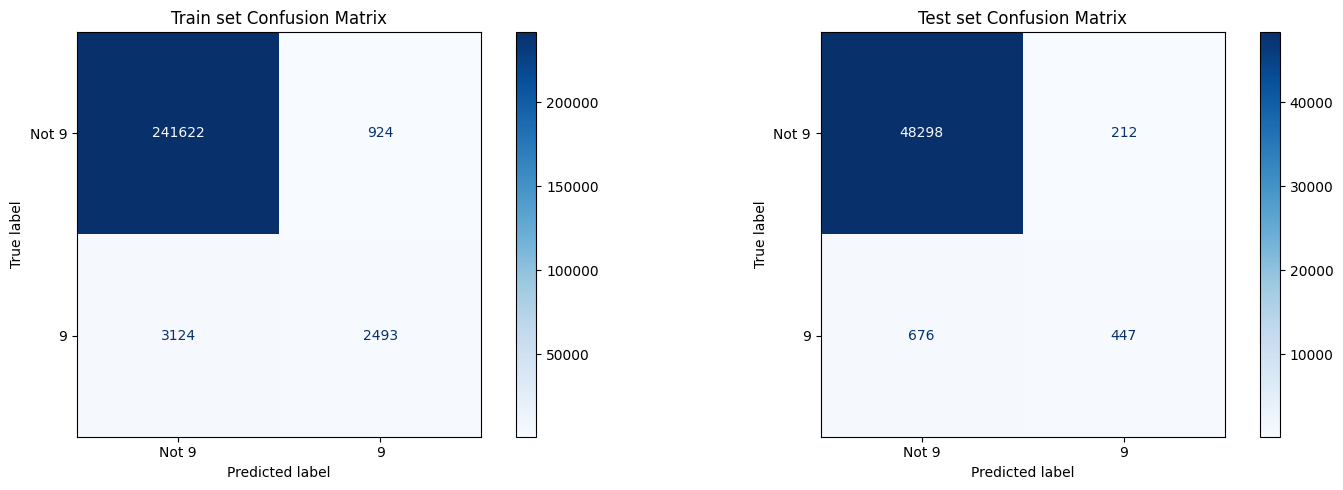

In [ ]:
### 모델별 결과 시각화 - 혼동행렬 - 최종 모델(xgboost)만
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 모델 예측
y_pred_proba_train = xgb_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]
y_pred_train = (y_pred_proba_train >= best_threshold_xgb).astype(int)
y_pred_test = (y_pred_proba_test >= best_threshold_xgb).astype(int)

# 혼동행렬 생성
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# 혼동행렬 시각화
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

disp_train = ConfusionMatrixDisplay(
    cm_train, #confusion matrix
    display_labels=['Not 9', '9']       # [음성레이블, 양성레이블]
)
disp_train.plot(cmap='Blues', ax=ax1)    # 출력

disp_test = ConfusionMatrixDisplay(
    cm_test, #confusion matrix
    display_labels=['Not 9', '9']) 

disp_test.plot(cmap='Blues', ax=ax2)

ax1.set_title("Train set Confusion Matrix")
ax2.set_title("Test set Confusion Matrix")
plt.tight_layout()
plt.savefig('Confusion_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()
